In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from omegaconf import open_dict
from hydra import compose, initialize

initialize(config_path="../config")

hydra.initialize()

In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Training (data taken from starfish MERFISH analysis notebook)

Load base config

In [6]:
# import tifffile
# img_paths = sorted(glob.glob(cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/*.tiff'))
# img_stack = np.stack([load_tiff_image(p) for p in img_paths], 0)
# img_stack = img_stack.reshape([16,1,2048, 2048], order='F')
# tifffile.imsave(cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff', data=img_stack)

In [7]:
# scale_facs = np.array([104.83 ,  87.186,  89.545, 107.29 ,  83.262,  79.469,  78.451, 67.742,  45.66 ,  41.184,  44.731,  50.718,  44.572,  41.757, 45.019,  44.622])

In [42]:
cfg = compose(config_name='train.yaml', overrides= ["exp_type=merfish"])
cfg = OmegaConf.create(cfg)

In [43]:
thetas = [0.287,0.216,0.377,0.321,0.278,0.255,0.483,0.219,0.616,0.374,0.394,0.358,0.44,0.414,0.447,0.244]

Make dataset specific changes

In [44]:
cfg.output.project = 'MERFISH_starfish'
# cfg.output.group='sweep_sl_4'
# cfg.sub_name='scaled'

# Path to the recording you want to train the network on. Can also use a * expression to load multiple tiffs (e.g. path/*.tif)
cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff'

cfg.exp_type.pred_z = False
cfg.exp_type.const_theta_sim = True
cfg.exp_type.phasing = False

# We initialize the PSF as a Gaussian with the given radii. Should be adjusted to get a rough visual fit between recording and simulation.
cfg.data_path.psf_path = None
cfg.PSF.psf_extent_zyx = [11,21,21]
cfg.PSF.gauss_radii = 1.7
cfg.PSF.n_cols = 1
# cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/MF_psf.tif'

cfg.evaluation.crop_sl = 's_[:,:,1500:1650,150:300]'
cfg.evaluation.px_size_zyx =  [100,100,100]

# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.foci.n_foci_avg = 1
# Lower and upper limit of emitters simulated per focus
cfg.foci.n_mol_range: [5,40]

# Sets the intensity scale of the simulation. Should be adjusted to cover observed intensity values 

cfg.prob_generator.low = 0.0002
cfg.prob_generator.high = 0.05

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'

cfg.model.f_maps = 256
cfg.model.depth = 2
cfg.training.bs = 5
cfg.noise.theta = thetas

cfg.roi_mask.percentile = 20

cfg.microscope.norm = 'none'
cfg.microscope.psf_noise = 0.3
cfg.bg_estimation.smoothing.smoothing_filter_size = 9

cfg.intensity_dist.int_conc = 4.
cfg.intensity_dist.int_rate = 1.
cfg.intensity_dist.int_loc = .5

cfg.training.num_iters = 50000
cfg.training.int.enabled = False

cfg.training.mic.enabled = False
cfg.training.shuffle_ch = False

cfg.training.bl_loss_scale: 0.005
# cfg.training.net.opt.lr = 2e-4

cfg.model.code_inf = True
cfg.training.net.min_int_sig = 1.0
cfg.microscope.scale = 60
cfg.bg_estimation.fractal.scale = 0

cfg.run_name ='MERFISH_ci_2d_sl14'

cfg.training.start_mic = 1e6
cfg.training.start_int = 1e6
cfg.evaluation.crop_sl = None
cfg.training.int_option = 3.

In [25]:
cfg.data_path.image_path = None
cfg.prob_generator.high = 0.15
cfg.foci.n_foci_avg = 0
cfg.data_path.image_shape = [16,1,48,48]
cfg.training.start_mic = 1e6
cfg.training.start_int = 1e6
cfg.training.net.bl_loss_scale = 0.
cfg.model.inp_scale = 300
cfg.model.inp_offset = 100
cfg.noise.theta = 0.35
cfg.microscope.psf_noise = 0.0
cfg.intensity_dist.int_conc = 1.0
cfg.training.int_option = 3.

cfg.run_name ='MERFISH_ci_2d_sim2'

In [45]:
fname = f'../config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'MERFISH_ci_2d_sl14'

In [41]:
home_dir = os.getenv("HOME")
print(f'bsub -gpu "num=1" -q gpu_rtx -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev2/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name} run_name={cfg.sub_name}')

bsub -gpu "num=1" -q gpu_rtx -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_ci_2d_sl14 run_name=None


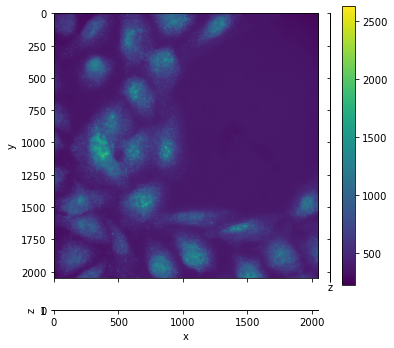

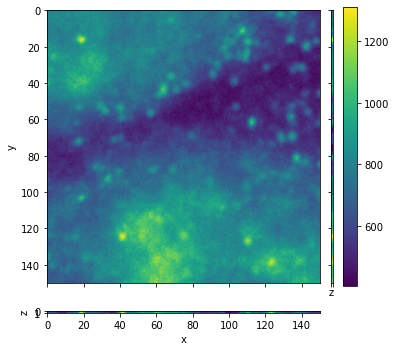

In [170]:
img = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[0])[0][None]
_ = plot_3d_projections(img, size=5, proj_func=np.max)
sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(img[sl[:]], size=5)

In [76]:
from scipy import stats
def estimate_noise_scale(img, bg_est, percentile=99, plot=True):
    """ Returns an estimate of theta given a volume and a background estimate 
    
    Args:
        img: recorded volume for which we want to estimate the noise 
        bg_est: estimated background for img
        percentile: we wan't to exclude the signal for our fit. therefore we only use the lower percentile of all voxels
        plot: whether to plot the data and the final fit
        
    Returns:
        fit_theta: theta estimate
    """
    
    img = cpu(img)
    bg_est = cpu(bg_est)
    residual = np.clip(img - bg_est + bg_est.mean(), img.min(), 1e10)
    fit_vals = residual[residual < np.percentile(residual, percentile)]
    fit_vals = fit_vals[fit_vals > np.percentile(fit_vals, 100-percentile)]
    fit_alpha, fit_loc, fit_theta=stats.gamma.fit(fit_vals, floc=0)   

    if plot:
        _ = plt.hist(fit_vals,bins=np.linspace(fit_vals.min(),fit_vals.max(), 51),  histtype ='step',label='data', density=True)
        x = np.linspace(fit_vals.min(),fit_vals.max(),101)
        y = stats.gamma.pdf(x, fit_alpha, fit_loc, fit_theta)
        plt.plot(x, y, label='Fit')
        plt.legend()
        
    return fit_theta

In [77]:
img = load_tiff_image(cfg.data_path.image_path)
thetas = []
for i in range(16):
    bg_est = hydra.utils.instantiate(cfg.bg_estimation.smoothing)(img[i,:,:500,1500:].to('cuda'))
    theta = estimate_noise_scale(img[i,:,:500,1500:], bg_est, percentile=99, plot=False)
#     plt.show()
    thetas.append(theta)

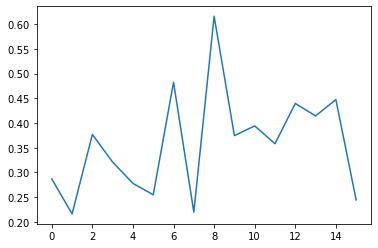

In [78]:
plt.plot(thetas)

Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [171]:
n_foci = cfg.foci.n_foci_avg
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.foci.n_foci_avg = n_foci

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


This function allows you to visually compare the recorded data and the simulations generated with the given config.  
For each sample we plot a slice from the input volume and from a simulated training volume as well as the estimated background.  
In the second row we compare maximum intensity projections.  

Adjust the microscope.scale and PSF.gauss_radii until you achieve a rough match in intensities and the PSF shape.  
You don't have to get this exactly right as these values get automatically fine tuned during training.
It is totally fine if average density of emitters in the simulations is higher than in the recordings.

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/output_trafo.py:19: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  b_inds = torch.cat([torch.tensor([0], device=x_os.device),((x_os[1:] - x_os[:-1]).nonzero() + 1)[:,0],


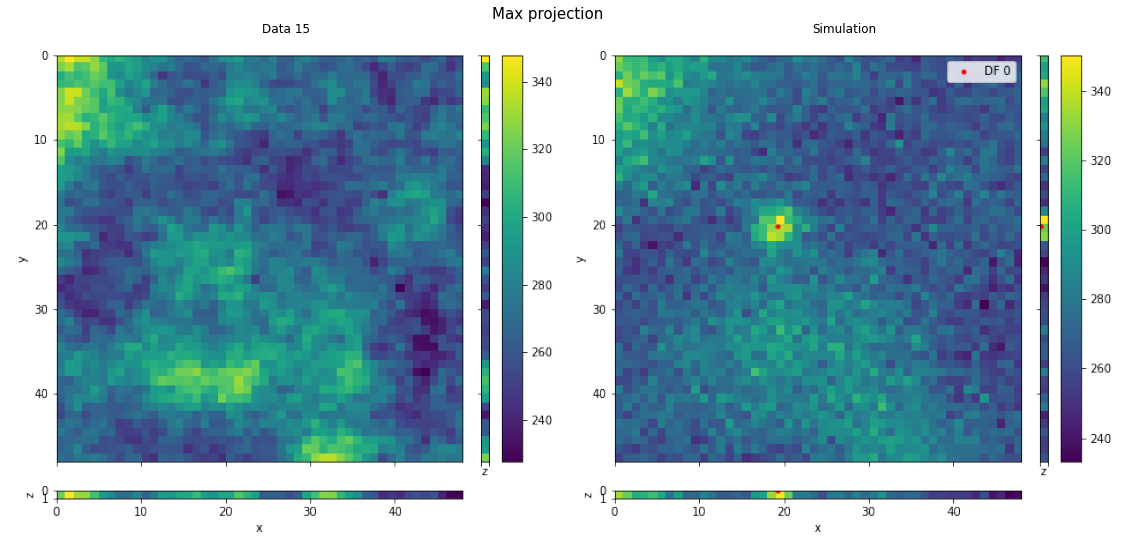

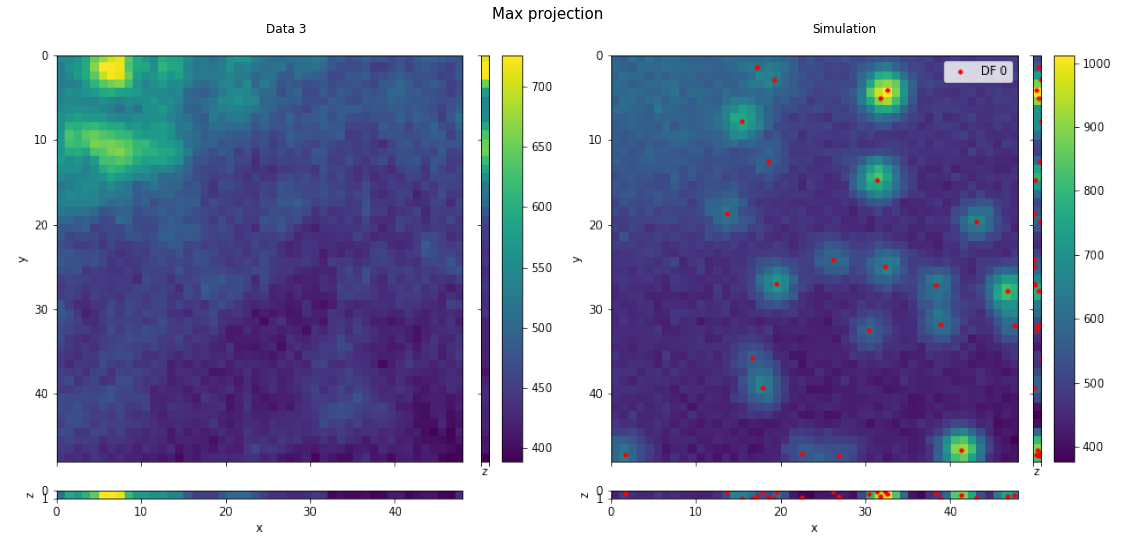

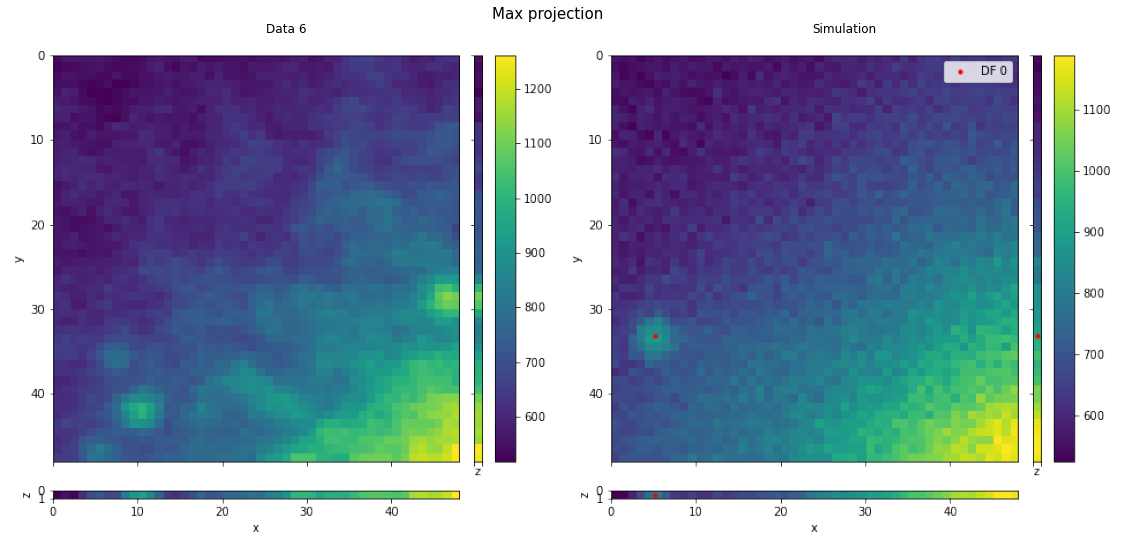

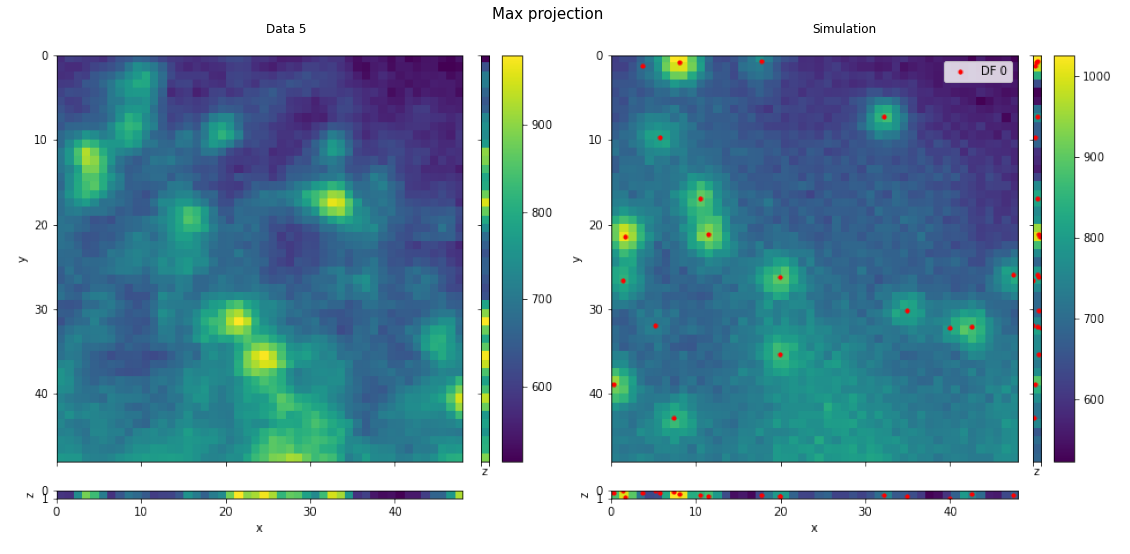

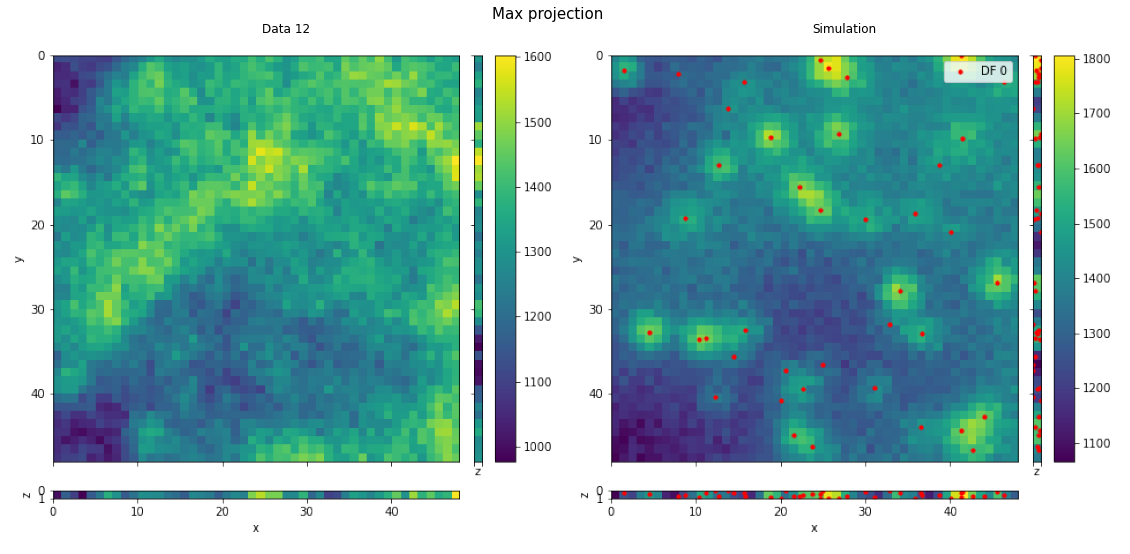

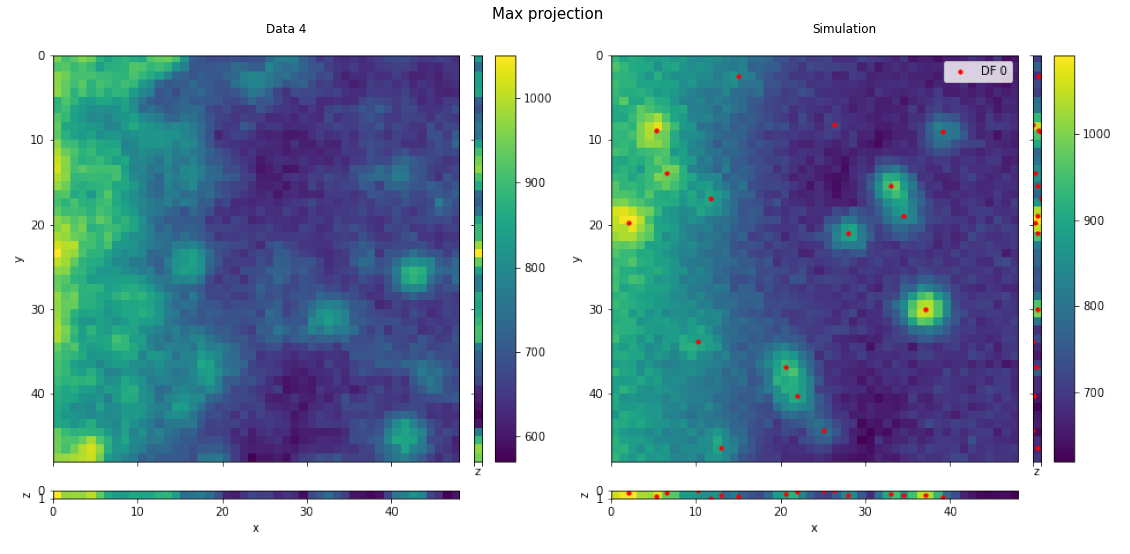

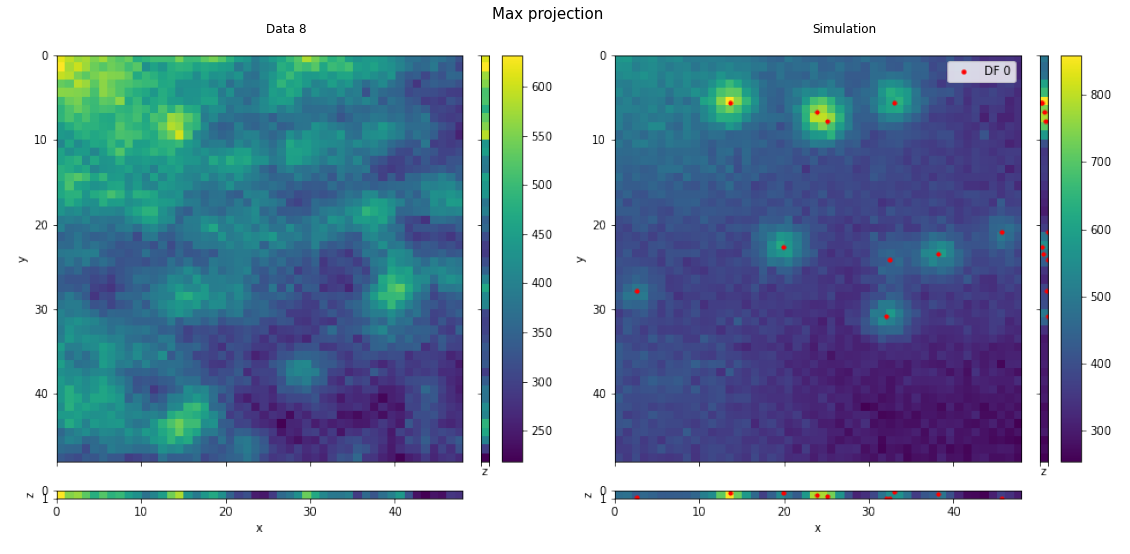

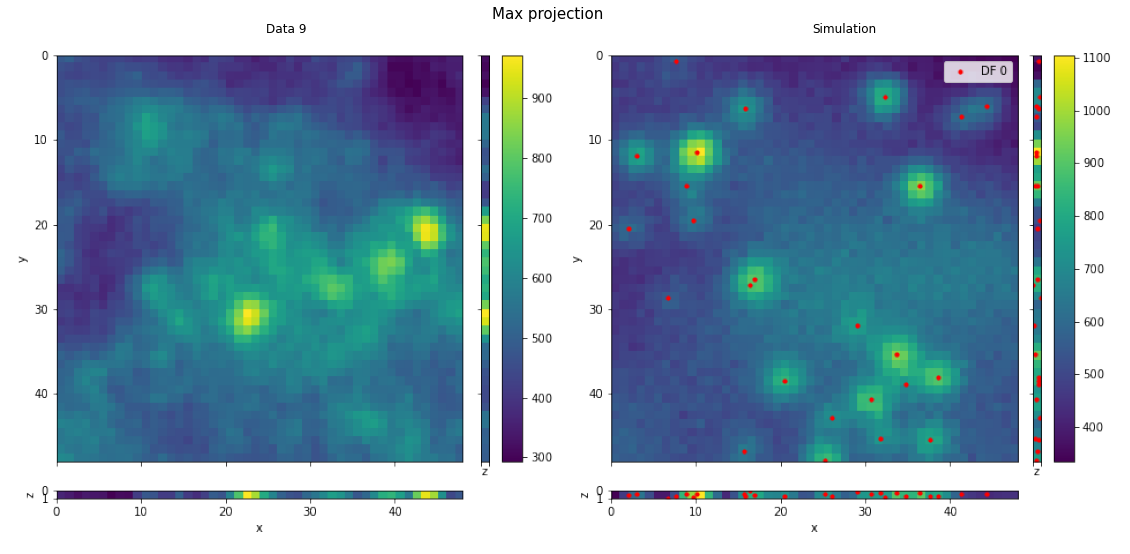

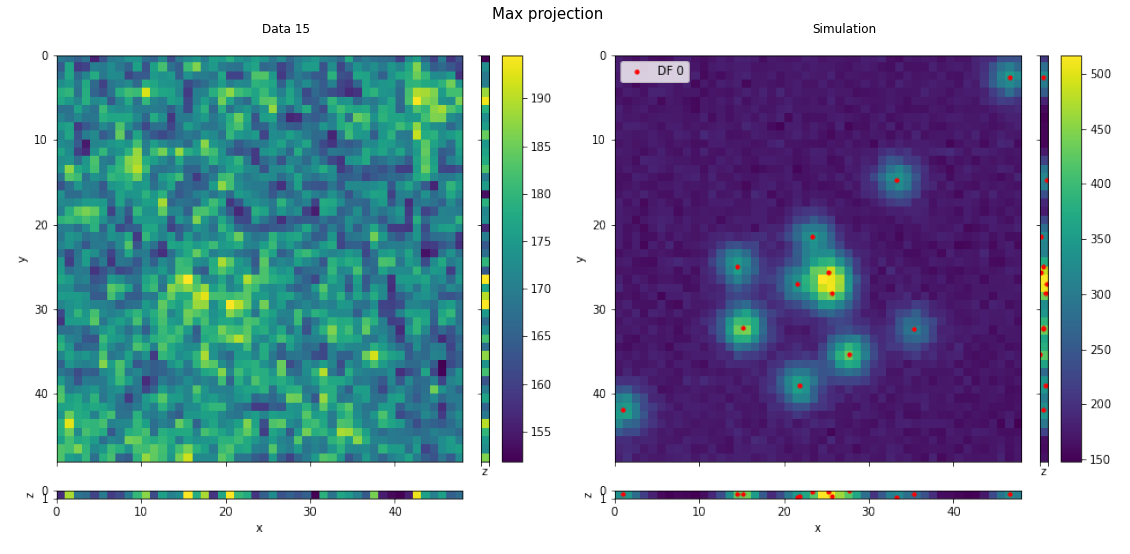

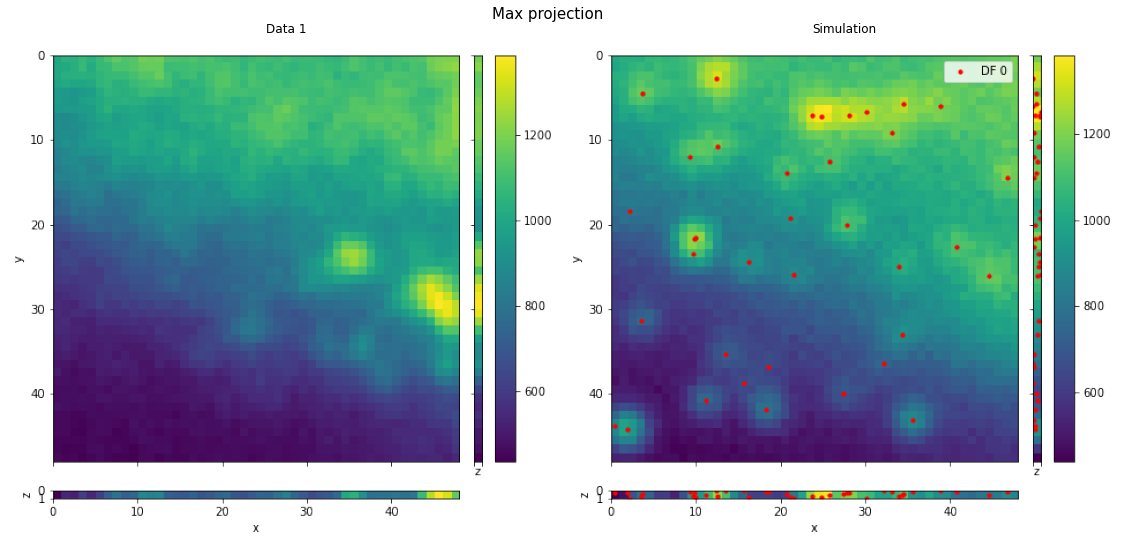

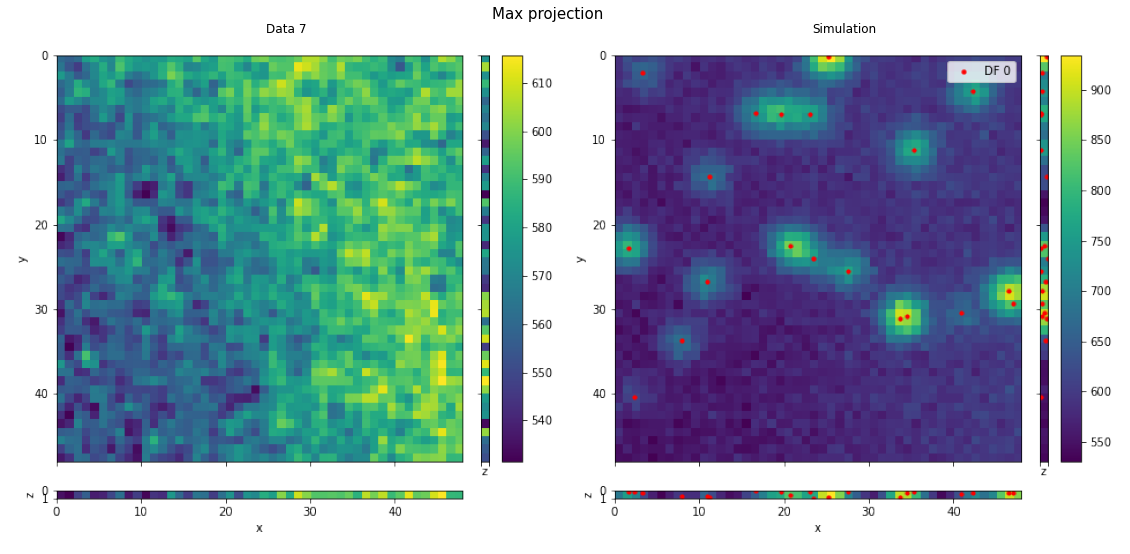

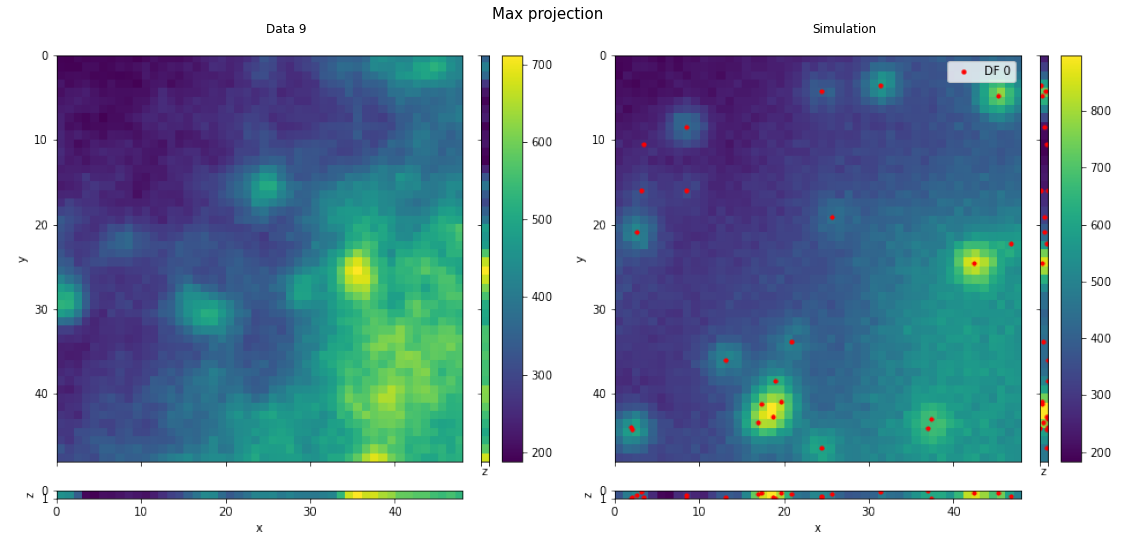

In [172]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=0.1, samples=12, channels=cfg.exp_type.channels, n_bits=cfg.exp_type.n_bits, psf_noise=False)

# Evaluation

In [4]:
# cfg.run_name = 'test'
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_14/enabled:Truexsample_from_codebook:Truexpsf_noise:0.4/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_9b/add_int_ps3/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_11/seed:1xint_fac:0.1xenabled:True//train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_11/seed:1xint_fac:0.1/train.yaml')

In [5]:
# cfg.exp_type.pred_z=False
# cfg.PSF.psf_extent_zyx=[1,21,21]

In [6]:
# cfg.exp_type.pred_z = False

In [7]:
# Load the model, post processing, imgages, dataloader
cfg.PSF.n_cols=1
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
# model, post_proc, _, _, _= load_all(cfg)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii, cfg.exp_type.pred_z, cfg.PSF.n_cols)
psf_init = cpu(psf_init.psf_volume)
psf_vol = cpu(micro.psf.psf_volume)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


Plot mean projections of the PSF before and after optimizing it during training

(tensor(0., device='cuda:0', grad_fn=<DivBackward0>), tensor(10., device='cuda:0', grad_fn=<DivBackward0>), tensor(10., device='cuda:0', grad_fn=<DivBackward0>))


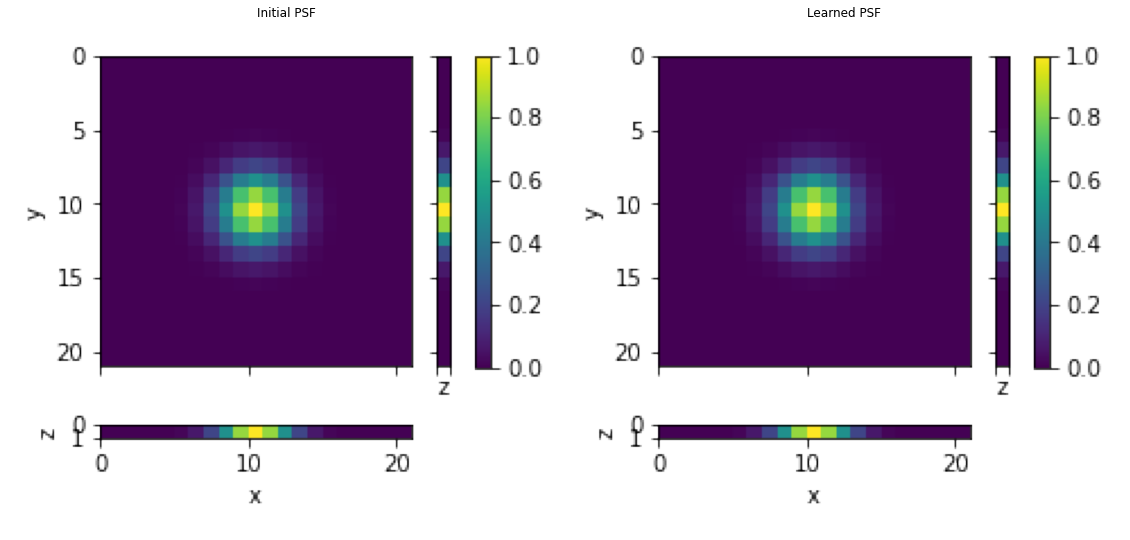

In [797]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_vol[0], proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_init[0], proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

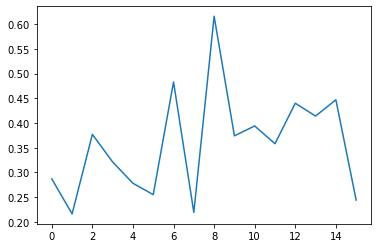

In [798]:
# plt.subplot(121)
plt.plot(cpu(micro.noise.theta_par.to('cpu')*micro.noise.theta_scale))
# plt.plot(ref_theta)

In [783]:
plt.plot(img_stack_o.mean(-1).mean(-1).mean(-1))
plt.plot(img_stack_s.mean(-1).mean(-1).mean(-1))

NameError: name 'img_stack_o' is not defined

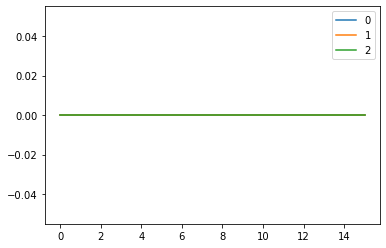

In [799]:
for i in range(3):
    plt.plot(cpu(micro.noise.channel_shifts[:,i]), label=i)
plt.legend()

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

In [215]:
# export
def get_prediction(model, post_proc, img, micro=None, cuda=True, return_rec=False, channel=0):
    
    with torch.no_grad():
        
        img = img[(None,)*(5-img.ndim)]
        model.eval().cuda() if cuda else model.eval().cpu()
        res_dict = model(img.cuda()) if cuda else model(img)
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)

        
        if return_rec:
            locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = post_proc.get_micro_inp(res_dict, channel=channel)
            ae_img_3d = micro(locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, rec_ch=channel)   
            return pred_df, ae_img_3d + res_dict['background'][:,channel:channel+1], res_dict
            
        return pred_df

def eval_random_crop(decode_dl, model, post_proc, micro, proj_func=np.max, cuda=False, samples=1, int_threshold=1, plot='rec', crop_sz_xy=40, ret_preds=False):
    
    with torch.no_grad():
        
        decode_dl.dataset.dataset_tfms[0].crop_sz = (decode_dl.dataset.dataset_tfms[0].crop_sz[0], crop_sz_xy, crop_sz_xy)
        
        if ret_preds: samples = 1
        
        for _ in range(samples):
        
            x = torch.zeros(1)
            while x.max() < int_threshold:
                x, local_rate, background = next(iter(decode_dl))
                
            rand_ch = np.random.randint(0, x.shape[1])
            
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[:1], micro=micro, cuda=True, return_rec=True, channel=rand_ch)
            pred_df = nm_to_px(pred_df, post_proc.px_size_zyx)
            
            pred_df = pred_df[pred_df[f'int_{rand_ch}'] > 0.03]

            x_plot = x[0,rand_ch].cpu().numpy()
            rec = rec[0,0].cpu().numpy()

            fig1, axes = plot_3d_projections(x_plot, proj_func=proj_func, display=False)
            scat_3d_projections(axes, [pred_df])
            
            if 'res' in plot:

                diff = abs(x_plot-rec)
                fig2, axes = plot_3d_projections(diff, proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'Residual'], figsize=(20,10))
  
            if 'rec' in plot:

                fig2, axes = plot_3d_projections(rec, proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'Reconstruction'], figsize=(20,10))
                
            if 'bg' in plot:

                fig2, axes = plot_3d_projections(res_dict['background'], proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'BG pred.'], figsize=(20,10))
                
        if ret_preds:
            
            return x, pred_df, rec, res_dict

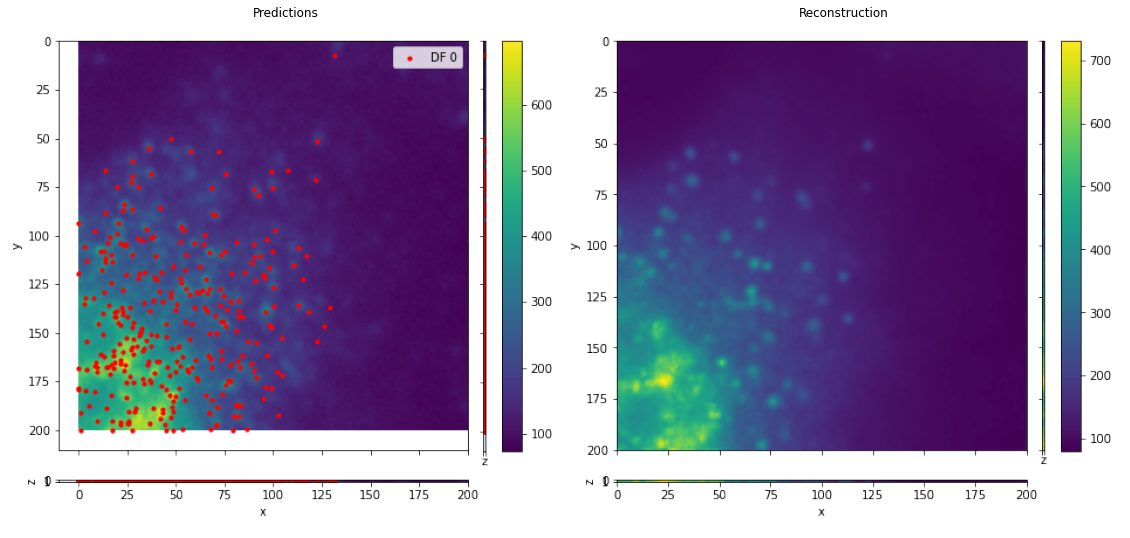

In [16]:
x, pred_df, rec, res_dict = eval_random_crop(decode_dl, model, post_proc, micro, samples=10, plot='rec', crop_sz_xy=200, ret_preds=True)

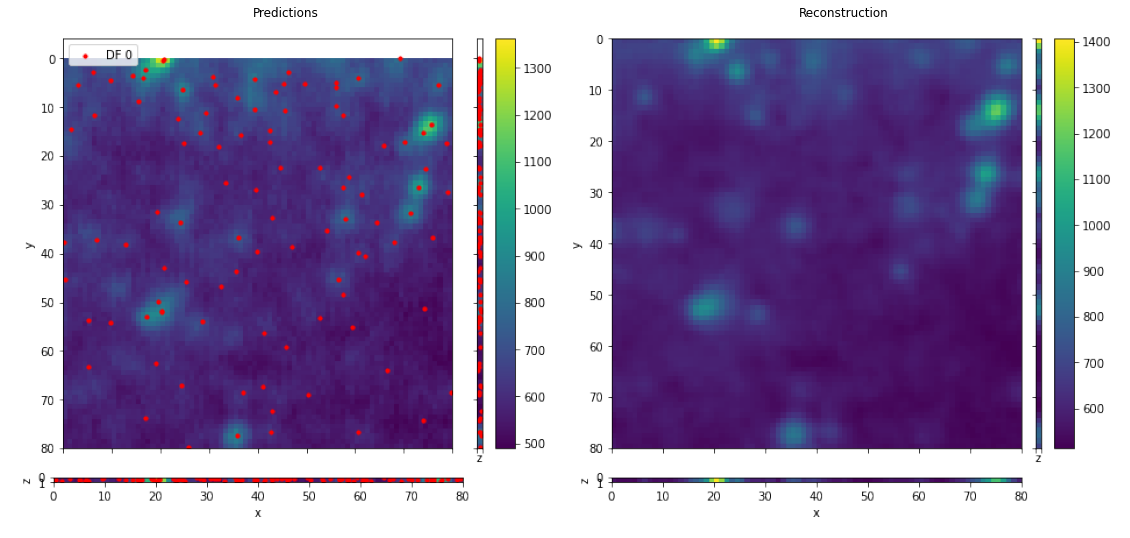

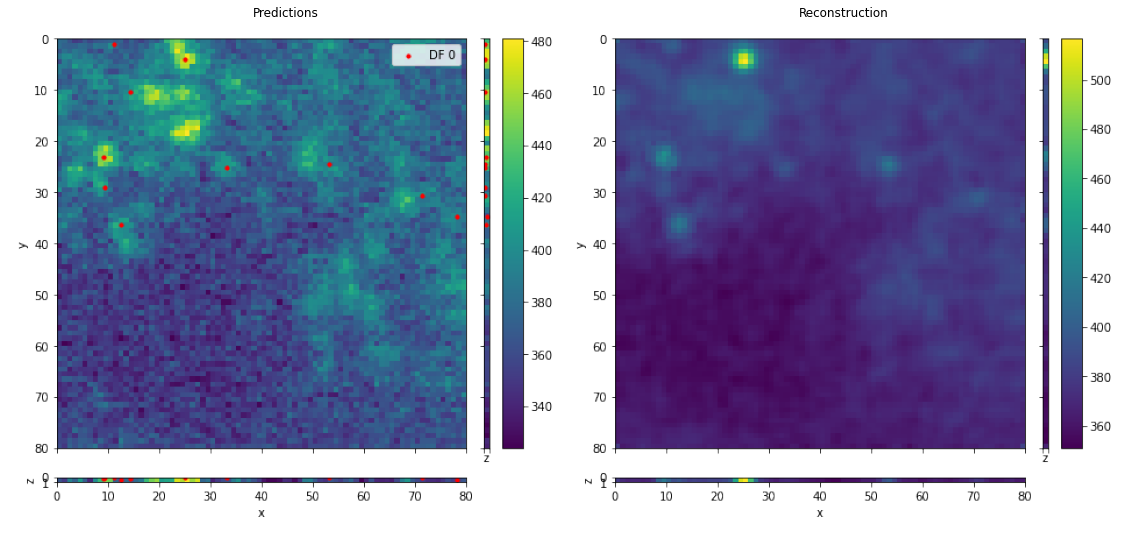

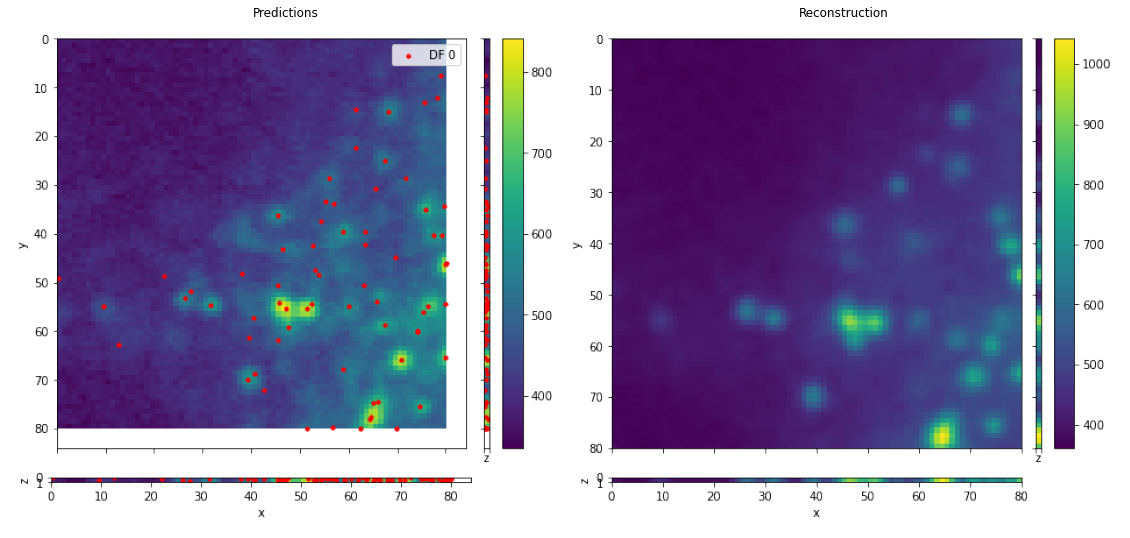

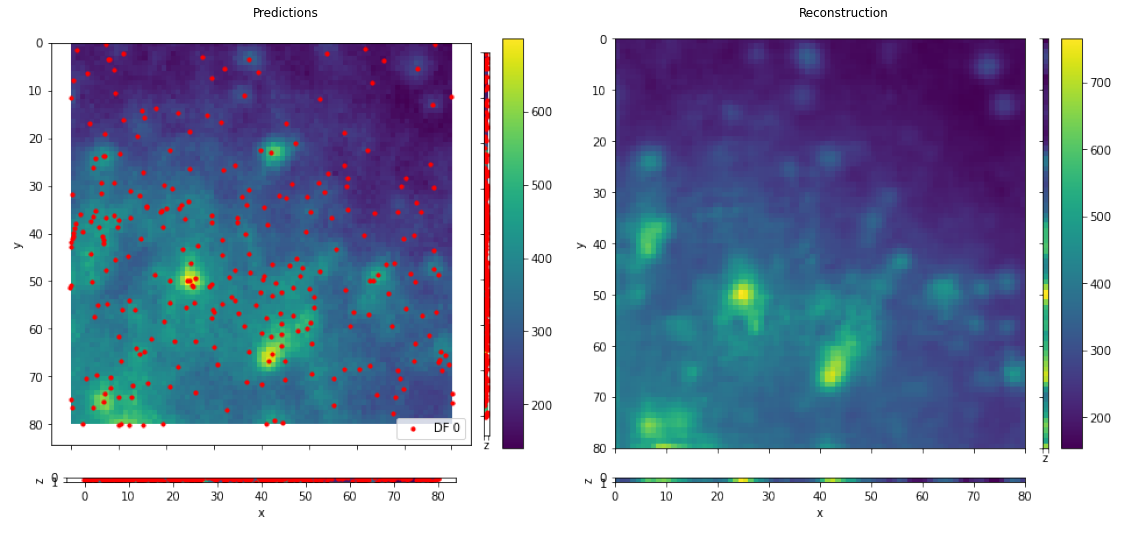

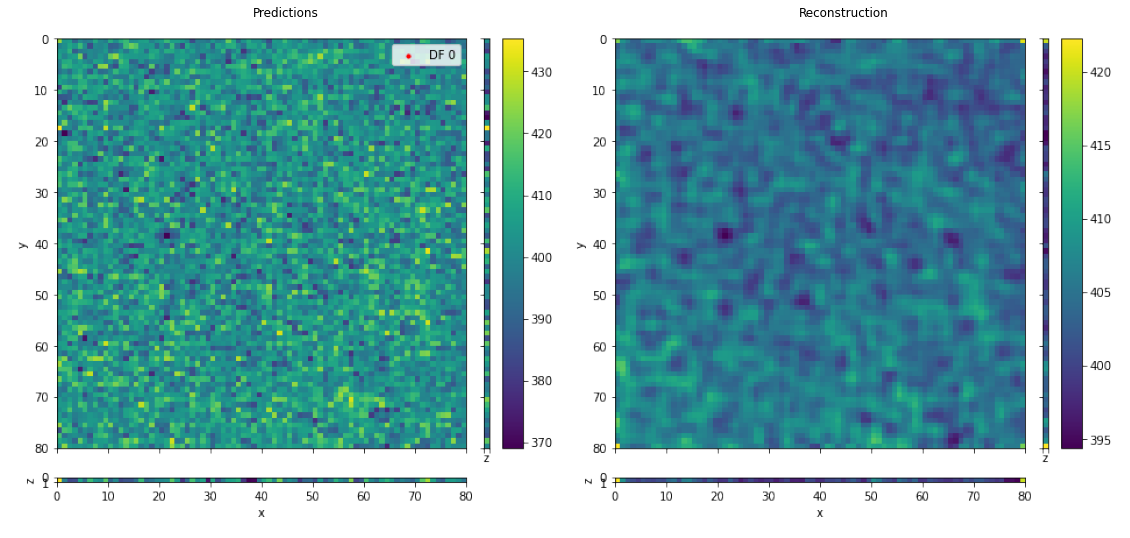

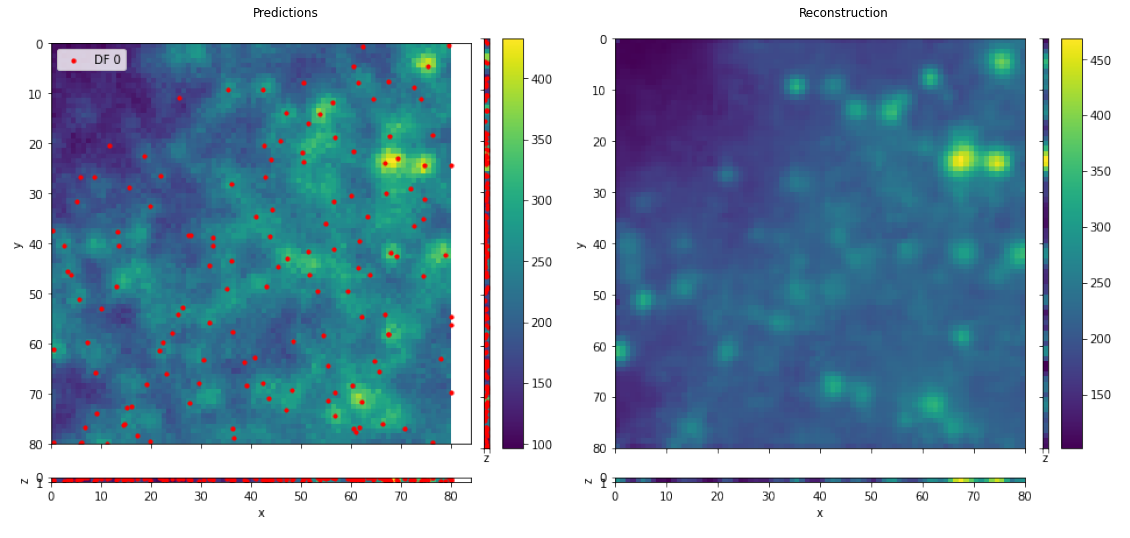

In [17]:
eval_random_crop(decode_dl, model, post_proc, micro, samples=6, plot='rec', crop_sz_xy=80)

In [4]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_9c/seed:1xmin_int_sig:0.0xbs:5xlr:0.0002///train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_9a/w_8b/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_11/seed:1xint_fac:0.1/train.yaml')

cfg.foci.n_foci_avg = 0
cfg.training.bs = 7
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [5]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.engine.gmm_loss import *

# micro.psf_noise = 0.4

with torch.no_grad():
#     x, local_rate, background = next(iter(decode_dl))
#     sim_vars = PointProcessUniform(local_rate*1.,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=16, n_bits=4, sim_z=cfg.exp_type.pred_z).sample()
#     xsim = micro(*sim_vars, add_noise=True)
#     xsimn = micro.noise(xsim, background).sample()

#     gt_vars = sim_vars[:-1]
#     gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])

    print(len(gt_df))

    model.eval().cuda()
    res_dict = model(xsimn.cuda())
    res_dict = model.tensor_to_dict(res_dict)
#     res_dict['xyzi_mu'][:,3:] = res_dict['xyzi_mu'][:,3:]# * 0  + torch.tensor(gt_ints)[:,:,None,None,None].cuda()
#     res_dict['xyzi_sigma'][:,3:] = res_dict['xyzi_sigma'][:,3:] 
#     count_prob, spatial_prob = PointProcessGaussian(**res_dict).log_prob(*sim_vars[:5], 
#                                                   n_bits=cfg.exp_type.n_bits, channels=cfg.exp_type.channels, min_int_sig=cfg.training.net.min_int_sig)
    
    pred_df = post_proc.get_df(res_dict)

NameError: name 'gt_df' is not defined

In [109]:
res_dict = post_proc.get_si_resdict(res_dict, None)

locations = res_dict['Samples_si'].nonzero(as_tuple=True)
locations = [l for l in locations]
x_os_3d = res_dict['xyzi_mu'][:,[0]][locations]
y_os_3d = res_dict['xyzi_mu'][:,[1]][locations]
z_os_3d = res_dict['xyzi_mu'][:,[2]][locations]
output_shape  = res_dict['Samples_si'].shape

# int_p_mask = torch.where(torch.sigmoid(res_dict['int_logits']) > 0.7, torch.ones_like(res_dict['int_logits']), torch.zeros_like(res_dict['int_logits']))
# ints_3d = (int_p_mask * res_dict['xyzi_mu'][:,3:])[:,[12]][locations] 

int_p_mask = torch.where(res_dict['int_logits'] >= res_dict['int_logits'].sort(1, descending=True).values[:,3:4], torch.ones_like(res_dict['int_logits']), torch.zeros_like(res_dict['int_logits']))
ints_3d = (int_p_mask * res_dict['xyzi_mu'][:,3:])[:,[12]][locations] 
# ints_3d = ints_3d[:,[channel]][locations] 

In [110]:
perf, matches, _ = matching(px_to_nm(gt_df), pred_df, tolerance=500, print_res=True)

Recall: 0.991
Precision: 0.975
Jaccard: 96.646
RMSE_vol: 27.464
Eff_3d: 85.864
FN: 3.0 FP: 8.0
Num. matches: 317.000
Shift: 1.78,0.11,0.00


In [111]:
p_pred = matches[[f'int_p_{i}_pred' for i in range(16)]].values
int_pred = matches[[f'int_{i}_pred' for i in range(16)]].values
ints_pred = matches[[f'int_sig_{i}_pred' for i in range(16)]].values
int_tar = matches[[f'int_{i}_tar' for i in range(16)]].values      
p_tar = np.where(int_tar>0,1,0)

In [112]:
corr1 = [np.corrcoef(p_pred[i], p_tar[i])[0,1] for i in range(len(p_pred))]    
corr2 = [np.corrcoef(int_pred[i], int_tar[i])[0,1] for i in range(len(p_pred))]    
corr3 = [np.corrcoef(p_pred[i], int_pred[i])[0,1] for i in range(len(p_pred))]    
corr4 = [np.corrcoef(ints_pred[i], int_pred[i])[0,1] for i in range(len(p_pred))]    
print(np.nanmean(corr1), np.nanmean(corr2), np.nanmean(corr3), np.nanmean(corr4))
print(p_pred.sum(-1).mean())

0.9413444282299749 0.949159822000495 0.9072631178024463 0.9666709372478303
4.040854186052976


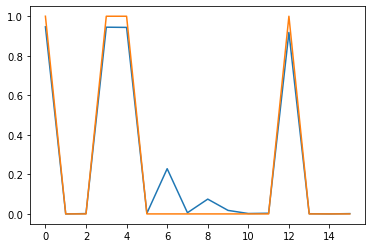

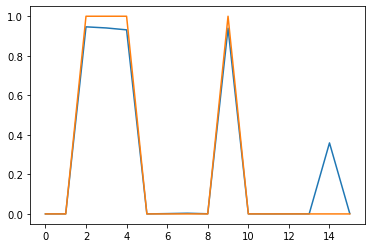

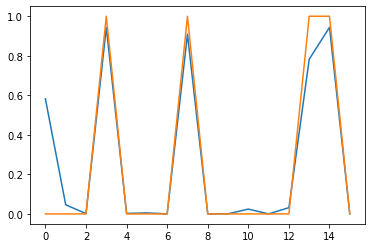

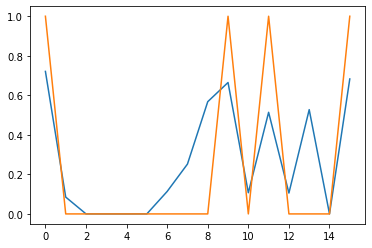

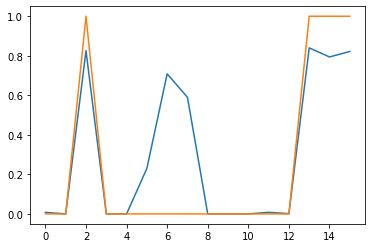

In [836]:
for i in [5,10,20,30,50]:
#     plt.plot(int_pred[i]/5)
#     plt.plot(int_tar[i])
    plt.plot(p_pred[i])
    plt.plot(p_tar[i])
    plt.show()

In [679]:
locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = post_proc.get_micro_inp(res_dict, channel=5) 
# locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape
filt_inds = [ints_3d >  0]
locations = [l[filt_inds] for l in locations]
x_os_3d, y_os_3d, z_os_3d, ints_3d = x_os_3d[filt_inds], y_os_3d[filt_inds], z_os_3d[filt_inds], ints_3d[filt_inds]

In [386]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *

def sim_data(decode_dl, batches, micro, model, channels=1, n_bits=1, sim_z=True):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            x, local_rate, background = next(iter(decode_dl))
            sim_vars = PointProcessUniform(local_rate*1. ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=channels, n_bits=n_bits, sim_z=sim_z).sample()
            xsim = micro(*sim_vars)
            x = micro.noise(xsim, background*0 + background.mean()).sample()

            xsim_col.append(x)
            gt_vars = sim_vars[:-1]
            gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True)
            pred_dfs.append(pred_df)
            x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=500, print_res=print_res)
    perf['mae'] = abs(xrec-rec).mean().item()
    perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    
    return perf, pred_df, matches, xrec


In [387]:
# from decode_fish.funcs.routines import *
xsim, gt = sim_data(decode_dl, 5, micro,model, channels=16, n_bits=4, sim_z=cfg.exp_type.pred_z)
perf, pred_df, matches, rec = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

Recall: 0.970
Precision: 0.964
Jaccard: 93.618
RMSE_vol: 41.585
Eff_3d: 78.250
FN: 70.0 FP: 84.0
Num. matches: 2259.000
Shift: -0.70,2.17,0.00


In [683]:
torch.sum(filt_inds[0])/len(filt_inds[0])

tensor(0.3083, device='cuda:0')

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [86]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_11/seed:1xint_fac:0.1/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_11/seed:1xint_fac:0.18xenabled:True/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_14/int_option:1//train.yaml')

In [87]:
# cfg.output.save_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/nb_run/test/'

In [88]:
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [89]:
from monai.inferers import sliding_window_inference
def merfish_predict(model, post_proc, image_paths, window_size=[None,256,256], device='cuda'):
    
    mixed_dfs = []
    
    for i in range(1):
    
        pred_df = DF()
        with torch.no_grad():
            for p in image_paths:
                print(p.split('/')[-1])
                img = load_tiff_image(p)[None]

                n_chans = img.shape[1]
                print(img.shape)
                z, y, x = img.shape[-3:]
                
#                 if i:
#                     ch_perm = list(np.random.permutation(np.arange(16)))
#                 else:
#                     ch_perm = np.arange(16)

                if i:
                    inp = img.flip(3)
                else:
                    inp = img
                output = sliding_window_inference(inp, window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                if i:
                    output = output.flip(3)
                output = model.tensor_to_dict(output)
                p_si = sliding_window_inference(output['logits'], window_size, 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                i_df = post_proc.get_df(output, p_si)
                print('N. emitters: ', len(i_df))
                i_df.loc[:,'frame_idx'] = 0
                pred_df = append_emitter_df(pred_df, i_df)
                free_mem()

#             pred_df[[f'int_{i}' for i in ch_perm]] = pred_df[[f'int_{i}' for i in np.arange(n_chans)]].values
            mixed_dfs.append(pred_df)
            
    return mixed_dfs

In [90]:
from decode_fish.funcs.merfish_eval import *
bench_df, code_ref, targets = get_benchmark()
bench_df = bench_df[bench_df['gene'] != 'MALAT1']

13832


In [91]:
image_paths = sorted(glob.glob(cfg.data_path.image_path))
image_paths = ['/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled//img_stack.tiff']
inf_dfs = merfish_predict(model, post_proc, image_paths, window_size=[None, 256, 256], device='cuda')
# inf_df.to_csv(f'../data/results/MERFISH/test.csv', index=False)

img_stack.tiff
torch.Size([1, 16, 1, 2048, 2048])
N. emitters:  25157


In [100]:
inf_dfs = [exclude_borders(df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100]) for df in inf_dfs]
res_df1 = inf_dfs[0]
res_df1['gene'] = targets[res_df1['code_inds']]
res_df1 = res_df1[res_df1['gene'] != 'MALAT1'] 

In [101]:
# res_df1.to_csv(f'../data/results/MERFISH/test.csv', index=False)

In [10]:
# res_df1 = get_code_from_ints(inf_dfs[0], code_ref, targets, bce_code, p_str='p_')

In [11]:
# _,matches,shift = matching(res_df1.nsmallest(35000, 'code_err'), res_df2.nsmallest(35000, 'code_err'), tolerance=200)
# print((matches['gene_pred']==matches['gene_tar']).sum()/len(matches))
# matches = matches[matches['gene_pred']==matches['gene_tar']]

In [12]:
# res_dfc = res_df1.set_index('loc_idx').loc[matches['loc_idx_tar']]
# res_dfc['loc_idx'] = res_dfc.index
# res_dfc = res_dfc.reset_index(drop=True)

[89.83694535701258, 89.33733714911062, 0.0]
Recall: 0.759
Precision: 0.635
Jaccard: 52.854
RMSE_vol: 85.605
Eff_3d: 36.323
FN: 3027.0 FP: 5472.0
Num. matches: 9528.000
Shift: 0.93,0.74,0.00

In [93]:
matches2, bench_match = match_bench(res_df1, bench_df)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


[88.50403830976761, 88.6599669892031, 0.0]
Recall: 0.748
Precision: 0.494
Jaccard: 42.369
RMSE_vol: 87.341
Eff_3d: 27.692
FN: 3163.0 FP: 9612.0
Num. matches: 9392.000
Shift: 1.30,1.36,0.00


12555 19004


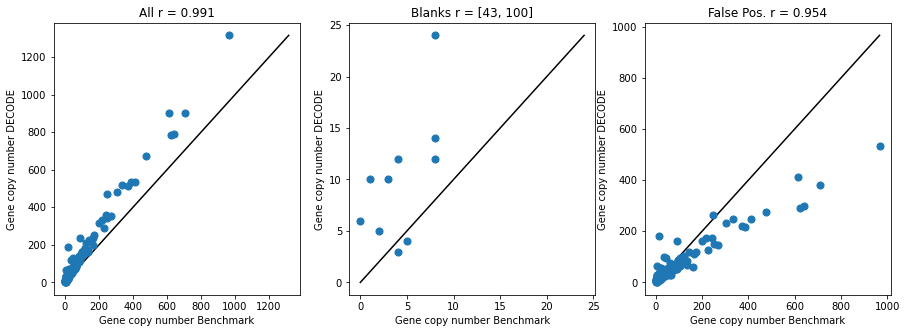

In [94]:
plot_gene_panels(res_df1, bench_match, matches2, targets)

12555 15000


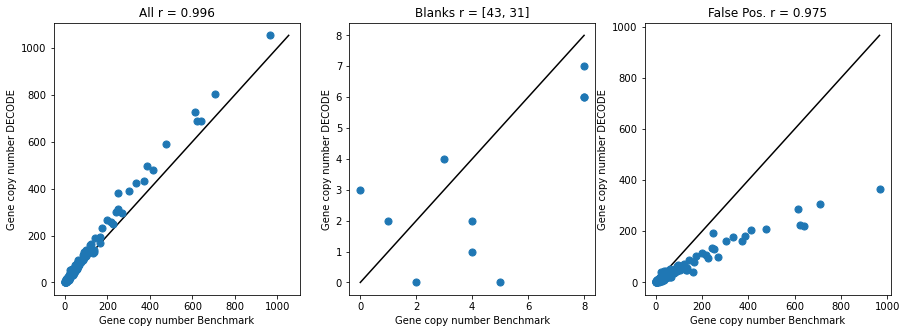

In [96]:
plot_gene_panels(res_df1.nsmallest(15000, 'comb_sig'), bench_match, matches2, targets)

12555 15000


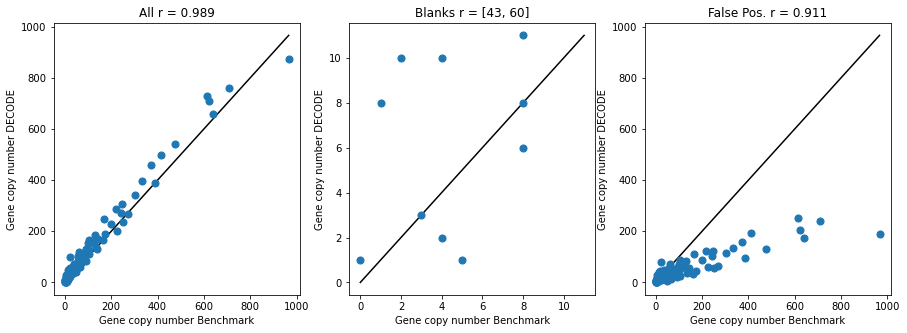

In [16]:
plot_gene_panels(res_df2.nsmallest(15000, 'code_err'), bench_match, matches2, targets)

In [99]:
res_df1.to_csv(f'../data/results/MERFISH/test.csv', index=False)

In [599]:
img_stack_o = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/img_stack.tiff')
img_stack_s = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled//img_stack.tiff')

In [227]:
# sl = np.s_[0,700:1200,300:800]
# # malat = 7,  8, 13, 14
# for i in range(16):

#     plt.figure(figsize=(20,8))
#     im = plt.imshow(img_stack[i][sl])
#     add_colorbar(im)

In [604]:
sl = np.s_[:,:,500:1250,1100:1700]
sl = np.s_[:,:,:,:]
img = load_tiff_image(image_paths[0])
for i in range(16):

    preds_px = nm_to_px(inf_df[inf_df['frame_idx']==(i)])
    plt.figure(figsize=(25,25))
    im = plt.imshow(img[i,0][sl[2:]])
    add_colorbar(im)
    sub_preds = crop_df(preds_px, sl)
    plt.scatter(sub_preds['x'],sub_preds['y'], color='red', s=3.5)
    plt.show()

TypeError: 'NoneType' object is not subscriptable

In [224]:
bla = res_df1.nsmallest(10000, 'code_err')

In [225]:
int_keys = [f'int_{i}' for i in range(16)]
p_keys = [f'int_p_{i}' for i in range(16)]
ints = bla.loc[:,int_keys].values
ps = bla.loc[:,p_keys].values

In [226]:
s_ints = np.take_along_axis(ints, ps.argsort(-1)[:,::-1], 1)[:,:4]
s_ps = np.take_along_axis(ps, ps.argsort(-1)[:,::-1], 1)

In [220]:
bla.groupby('gene')['gene'].count().sort_values()

gene
NHSL2        1
CNR2         1
MCF2L        1
TMOD2        1
SULT1C2      1
          ... 
TLN1       472
FASN       540
SPTBN1     567
THBS1      568
SRRM2      814
Name: gene, Length: 129, dtype: int64

In [217]:
kk.sort_values()

gene
NHSL2        1
CNR2         1
MCF2L        1
TMOD2        1
SULT1C2      1
          ... 
TLN1       472
FASN       540
SPTBN1     567
THBS1      568
SRRM2      814
Name: gene, Length: 129, dtype: int64

In [221]:
gname = 'TLN1'
flub = bla[bla['gene']==gname].loc[:, int_keys].values
inds = code_ref[np.where(targets == gname)[0]][0].nonzero()[0]

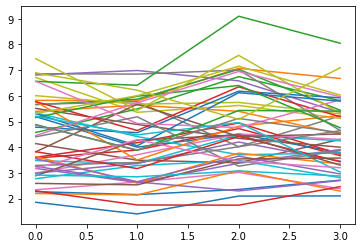

In [222]:
for f in flub[:50,inds]:
    plt.plot(f)

Text(0.5, 0, 'four highest probablities')

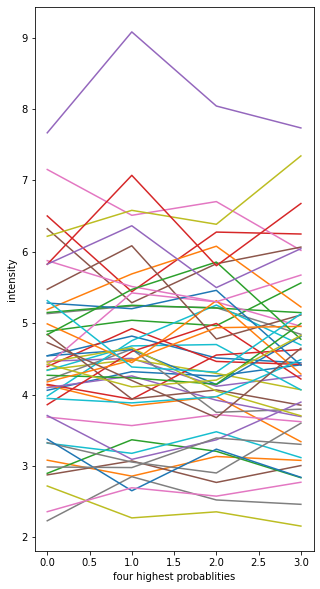

In [235]:
plt.figure(figsize=(5,10))
for i in range(50):
    plt.plot(s_ints[i])
plt.ylabel('intensity')
plt.xlabel('four highest probablities')